#Siamese network
This notebook will illustrate the use of siamese network to find similarity netween two images but concept can be extended for any type of data structured or unstructured. We will pass the two images in same network to get corresponding vectors of images and then will use distances metrics to quantify distance between two images



#Import

In [69]:
import pandas as pd
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K

#Methods

In [70]:
def create_pairs(x, digit_indices):
    '''
    Tow create pairs of images, images with same label will be paired together with label as 1
    images with different label will paired together with label as 0
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y
def euclidean_distance(vects):
    '''
    To calculate distance between two vector
    '''
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [71]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

In [72]:
def base_network():
  '''
  base network where we will pass two images
  '''
  input = Input(shape=(28, 28), name='base_input')
  x = Flatten(name='Flatten')(input)
  x = Dense(128, activation='relu', name = 'first_dense')(x)
  x = Dropout(0.2, name='first_dropout')(x)
  x = Dense(128, activation='relu', name='second_dense')(x)
  x = Dropout(0.2, name='second_dropout')(x)
  x = Dense(128, activation='relu', name='third_dense')(x)
  model = Model(inputs=input, outputs=x)
  return model

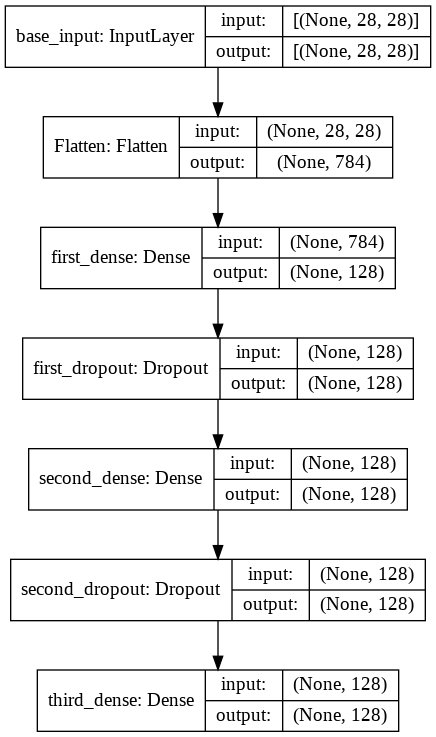

In [73]:
base_network = base_network()
plot_model(base_network, show_shapes=True)

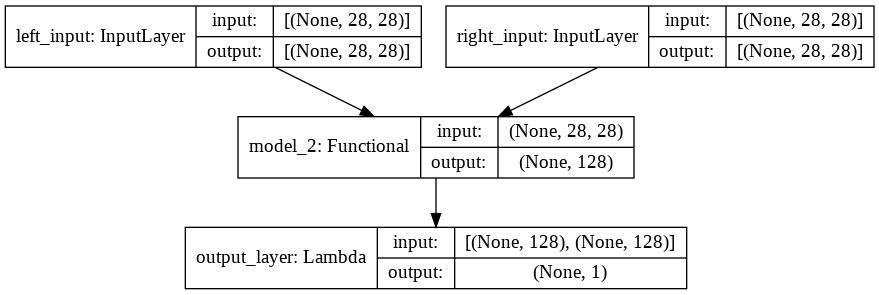

In [48]:
#Create Left Input and pass to base network
input_a = Input(shape=(28,28), name='left_input')
vec_output_a = base_network(input_a)
#Create right Input
input_b = Input(shape=(28, 28), name='right_input')
vec_output_b = base_network(input_b)
#Get Euclidean distance
output = Lambda(euclidean_distance, name='output_layer', output_shape=eucl_dist_output_shape)([vec_output_a, vec_output_b])
model = Model(inputs=[input_a, input_b], outputs=output)
plot_model(model, show_shapes=True)

# Train

In [49]:
#define loss
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    y_pred_square = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.maximum(margin-y_pred, 0))
    c_loss = tf.math.reduce_mean(y_true * y_pred_square + (1 - y_true) * margin_square)
    return c_loss
  return contrastive_loss

In [74]:
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam, loss=contrastive_loss_with_margin(margin=1))

In [75]:
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=10, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0705 - val_loss: 0.0694
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0689 - val_loss: 0.0729
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0677 - val_loss: 0.0697
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0676 - val_loss: 0.0694
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0665 - val_loss: 0.0708
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0660 - val_loss: 0.0715
Epoch 7/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0649 - val_loss: 0.0694
Epoch 8/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0642 - val_loss: 0.0706
Epoch 9/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0630 - val_loss: 0.0685
Epoch 10/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0639 - val_loss: 0.0681

# Evaluation

In [76]:
def create_output(dist, y_pred):
  '''
  if distance is < thresold output 1 else 0
  '''
  pred = []
  for y in y_pred:
    if y < dist:
      pred.append(1.0)
    else:
      pred.append(0.0)
  return pred

In [53]:
train_pred = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
pred = create_output(0.5, train_pred)
print("Training Accuracy: {}".format(accuracy_score(tr_y, pred)))

Training Accuracy: 0.9192698783130522


In [54]:
val_pred = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
val_pred = create_output(0.5, val_pred)
print("Validation Accuracy: {}".format(accuracy_score(ts_y, val_pred)))

Validation Accuracy: 0.9048548548548548


# Manual Evaluation

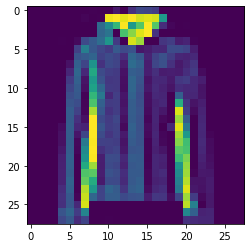

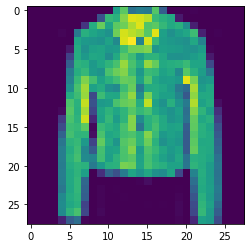

In [62]:
#Testing images with label 4
indices_4 = np.where(test_labels == 4)[0][0:2]
for idx in indices_4:
  plt.figure()
  plt.imshow(test_images[idx])

In [68]:
#Distance between images having same labels is < 0.5
model.predict([np.expand_dims(test_images[indices_4[0]], axis=0), np.expand_dims(test_images[indices_4[1]], axis=0)])

array([[0.17160079]], dtype=float32)

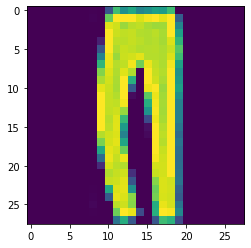

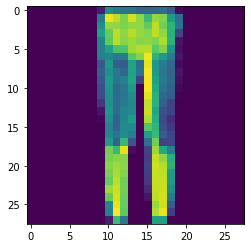

In [64]:
#Testing images with label 1
indices_1 = np.where(test_labels == 1)[0][0:2]
for idx in indices_1:
  plt.figure()
  plt.imshow(test_images[idx])

In [59]:
#Distance between images with same label is <0.5
model.predict([np.expand_dims(test_images[indices_1[0]], axis=0), np.expand_dims(test_images[indices_1[1]], axis=0)])

array([[0.01842847]], dtype=float32)

In [60]:
#Distance between images with two different label is > 0.5
model.predict([np.expand_dims(test_images[indices_4[0]], axis=0), np.expand_dims(test_images[indices_1[0]], axis=0)])

array([[0.9792071]], dtype=float32)

In [61]:
#Distance between images with two different label is > 0.5
model.predict([np.expand_dims(test_images[indices_4[1]], axis=0), np.expand_dims(test_images[indices_1[1]], axis=0)])

array([[1.0538912]], dtype=float32)